# MPI calibration of a Grid5000 cluster

## Data exploration

In [1]:
import os
import zipfile
import yaml
import pandas
import io

archive_name = 'grenoble_2018-08-29_1808878.zip'

def extract_zip(zip_name):
    '''Taken from https://stackoverflow.com/a/10909016/4110059'''
    input_zip = zipfile.ZipFile(zip_name)
    result = {}
    deployment = yaml.load(input_zip.read('info.yaml'))['deployment']
    experiment = zip_name
    if '/' in experiment:
        experiment = experiment[experiment.index('/')+1:]
    experiment = experiment[:experiment.index('_')]
    for name in input_zip.namelist():
        if name.endswith('.csv'):
            dataframe = pandas.read_csv(io.BytesIO(input_zip.read(name)), names = ['op', 'msg_size', 'start', 'duration'])
            dataframe['experiment'] = experiment
            dataframe['type'] = name
            dataframe['deployment'] = deployment
            dataframe['index'] = range(len(dataframe))
            result[name] = dataframe
        elif name.endswith('.yaml'):
            result[name] = yaml.load(input_zip.read(name))
        else:
            result[name] = input_zip.read(name)
    return result

def aggregate_dataframe(dataframe):
    df = dataframe.groupby('msg_size').mean().reset_index()
    for col in dataframe.columns:
        if col not in df.columns:
            value = list(dataframe[col].unique())
            if len(value) == 1:
                df[col] = value[0]
    return df

threshold = 8133

# I really hate that we have to define these two values:
expected_bandwidth = 1e11/8
expected_latency   = 1e-7

result = extract_zip(archive_name)

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
!unzip -p $archive_name info.yaml

cluster: dahu
command: /home/tocornebize/.local/bin/peanut MPICalibration run tocornebize --jobid
  grenoble:1808878 --deploy debian9-x64-base --expfile exp.csv
dahu-11.grenoble.grid5000.fr:
  arp:
    dahu-15.grenoble.grid5000.fr:
    - (172.16.20.15) at 3c:fd:fe:55:ed:60 [ether] on enp24s0f0
    dns.grenoble.grid5000.fr:
    - (172.16.31.110) at 00:16:3e:4f:65:bf [ether] on enp24s0f0
    fgrenoble.grenoble.grid5000.fr:
    - (172.16.31.101) at 00:16:3e:06:dd:61 [ether] on enp24s0f0
    gw.grenoble.grid5000.fr:
    - (172.16.31.254) at 00:04:96:1d:09:40 [ether] on enp24s0f0
    kadeploy.grenoble.grid5000.fr:
    - (172.16.31.102) at 00:16:3e:c8:38:51 [ether] on enp24s0f0
  cpu: Intel(R) Xeon(R) Gold 6130 CPU @ 2.10GHz
  gcc: 6.3.0
  kernel: 4.9.0-7-amd64
  mpi: mpirun (Open MPI) 2.0.2
  version: 'Linux version 4.9.0-7-amd64 (debian-kernel@lists.debian.org) (gcc version
    6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.110-3+deb9u1 (2018-08-03)'
dahu-15.grenoble.grid5000.

In [3]:
import pytree
print(pytree.__version__)
print(pytree.__git_version__)

0.0.6
daeffcbfbfb10dc9d69044bb110f965ab4e4e042


In [4]:
# Special processing for the Pingpong dataset
df_pingpong = result['exp/exp_PingPong.csv']
pingpong_send = df_pingpong[df_pingpong.op=='MPI_Send'].reset_index(drop=True)
pingpong_recv = df_pingpong[df_pingpong.op=='MPI_Recv'].reset_index(drop=True)
df_pingpong = pandas.DataFrame(dict(op = 'PingPong',
                   msg_size = pingpong_send.msg_size,
                   start    = pingpong_send.start,
                   duration = pingpong_recv.duration + pingpong_send.duration
              ))

df_send = pingpong_send
df_isend = result['exp/exp_Isend.csv']
df_recv = result['exp/exp_Recv.csv']
df_wtime = result['exp/exp_Wtime.csv']
df_test = result['exp/exp_Test.csv']
df_iprobe = result['exp/exp_Iprobe.csv']

### MPI_Send

In [5]:
import pytree
import matplotlib.pyplot as plt

tmp = aggregate_dataframe(df_send)
reg_send = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_send.breakpoints)
reg_send

[8133, 33956, 63305, 77895]


-inf < x ≤ 8.133e+03
	y ~ 9.636e-11x + 2.965e-07
8.133e+03 < x ≤ 3.396e+04
	y ~ 1.044e-10x + 4.052e-06
3.396e+04 < x ≤ 6.330e+04
	y ~ 1.264e-10x + 8.556e-06
6.330e+04 < x ≤ 7.790e+04
	y ~ 1.825e-10x + 7.826e-06
7.790e+04 < x ≤ inf
	y ~ 8.050e-11x + 1.635e-05

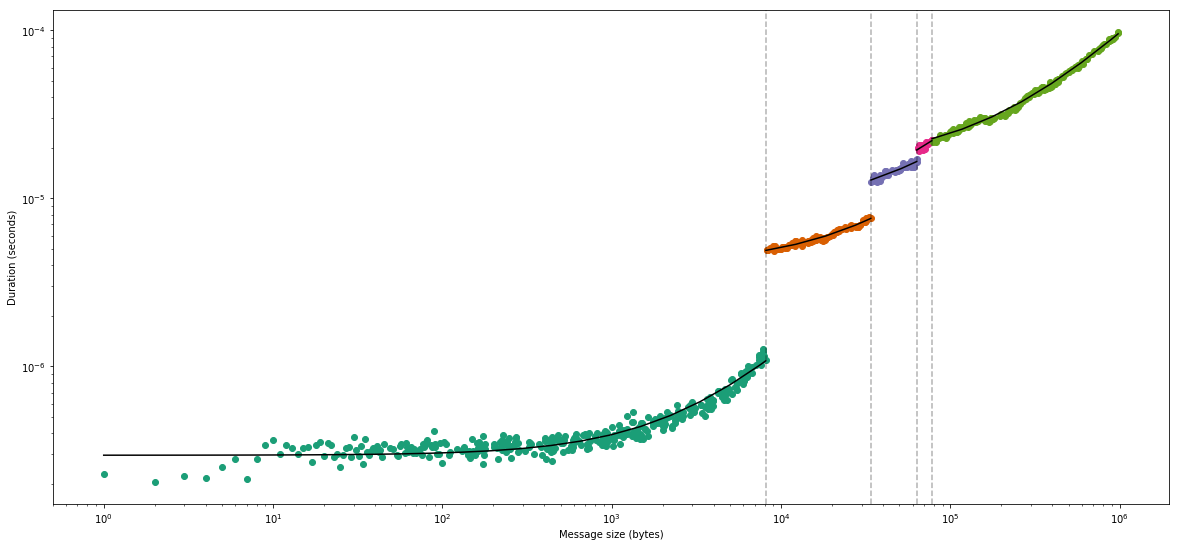

In [6]:
def draw_plot(reg, alpha=1, use_statsmodels=False):
    reg.plot_dataset(log=True, alpha=alpha, use_statsmodels=use_statsmodels)
    plt.xlabel('Message size (bytes)')
    plt.ylabel('Duration (seconds)')

draw_plot(reg_send)

In [7]:
breakpoints_send = set(reg_send.breakpoints)
breakpoints_send.difference_update([77895])
breakpoints_send

{8133, 33956, 63305}

### MPI_Isend

In [8]:
tmp = aggregate_dataframe(df_isend)
reg_isend = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_isend.breakpoints)
reg_isend

[10079, 15831, 63305]


-inf < x ≤ 1.008e+04
	y ~ 7.071e-11x + 6.931e-07
1.008e+04 < x ≤ 1.583e+04
	y ~ 5.382e-11x + 1.329e-06
1.583e+04 < x ≤ 6.330e+04
	y ~ 3.206e-11x + 3.192e-06
6.330e+04 < x ≤ inf
	y ~ -8.507e-14x + 6.940e-07

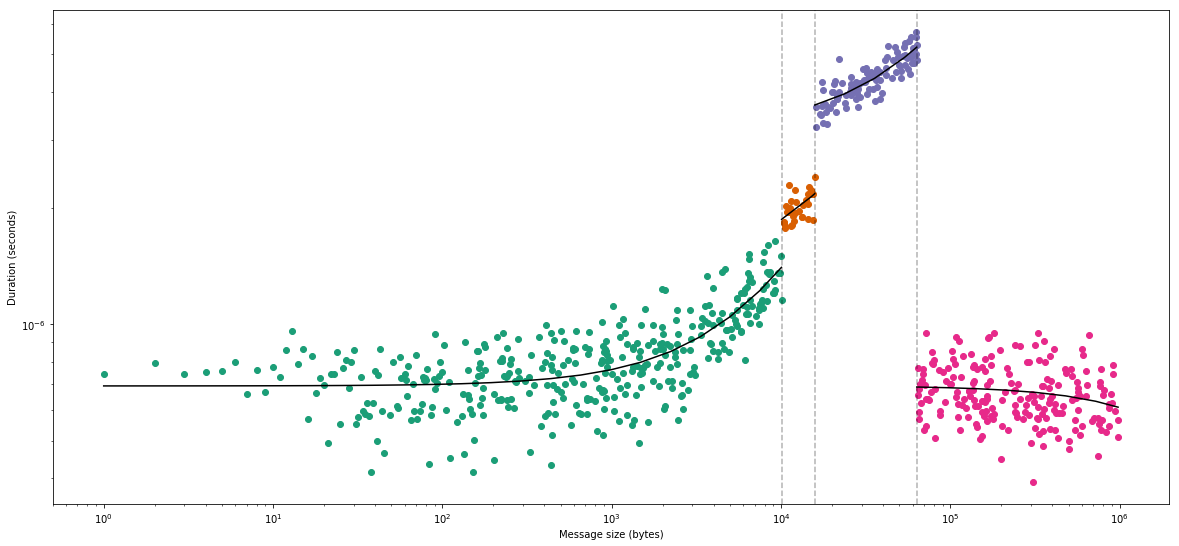

In [9]:
draw_plot(reg_isend)

In [10]:
breakpoints_isend = set(reg_isend.breakpoints)
breakpoints_isend

{10079, 15831, 63305}

### MPI_Recv

In [11]:
tmp = aggregate_dataframe(df_recv)
reg_recv = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_recv.breakpoints)
reg_recv

[8260, 33956, 63305, 415013]


-inf < x ≤ 8.260e+03
	y ~ 8.432e-11x + 1.376e-06
8.260e+03 < x ≤ 3.396e+04
	y ~ 1.032e-10x + 1.080e-06
3.396e+04 < x ≤ 6.330e+04
	y ~ 1.074e-10x + 1.303e-06
6.330e+04 < x ≤ 4.150e+05
	y ~ 7.970e-11x + 1.101e-05
4.150e+05 < x ≤ inf
	y ~ 8.101e-11x + 9.882e-06

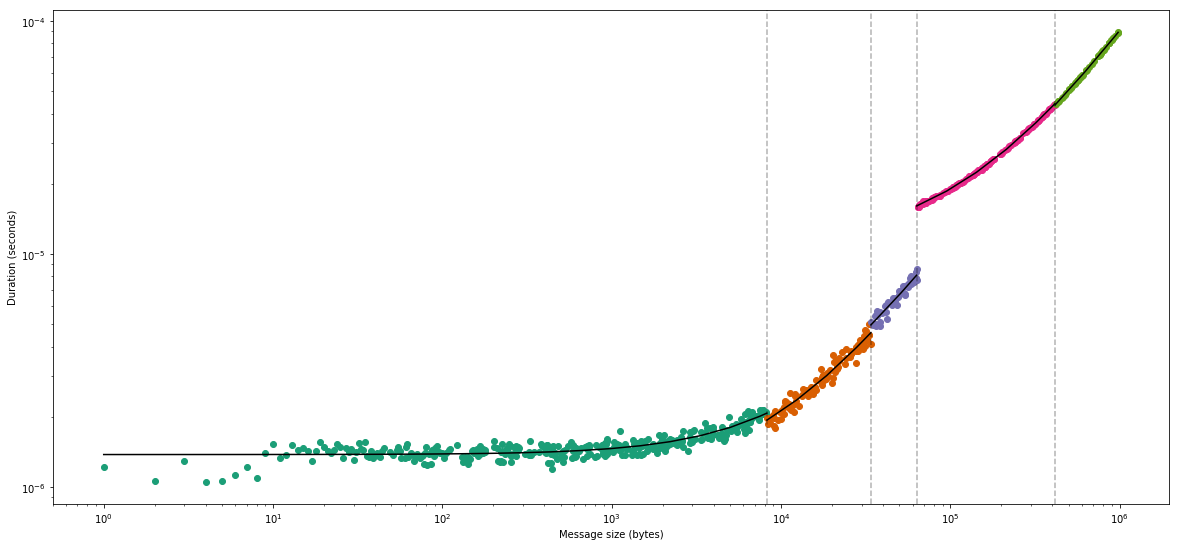

In [12]:
draw_plot(reg_recv)

In [13]:
breakpoints_recv = set(reg_recv.breakpoints)
breakpoints_recv.difference_update([33956, 415013])
breakpoints_recv

{8260, 63305}

### Pingpong

In [14]:
tmp = aggregate_dataframe(df_pingpong)
reg_pingpong = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_pingpong.breakpoints)
reg_pingpong

[8133, 33956, 63305, 158541]


-inf < x ≤ 8.133e+03
	y ~ 4.920e-10x + 2.994e-06
8.133e+03 < x ≤ 3.396e+04
	y ~ 2.239e-10x + 6.104e-06
3.396e+04 < x ≤ 6.330e+04
	y ~ 2.275e-10x + 1.293e-05
6.330e+04 < x ≤ 1.585e+05
	y ~ 1.953e-10x + 2.256e-05
1.585e+05 < x ≤ inf
	y ~ 1.626e-10x + 2.554e-05

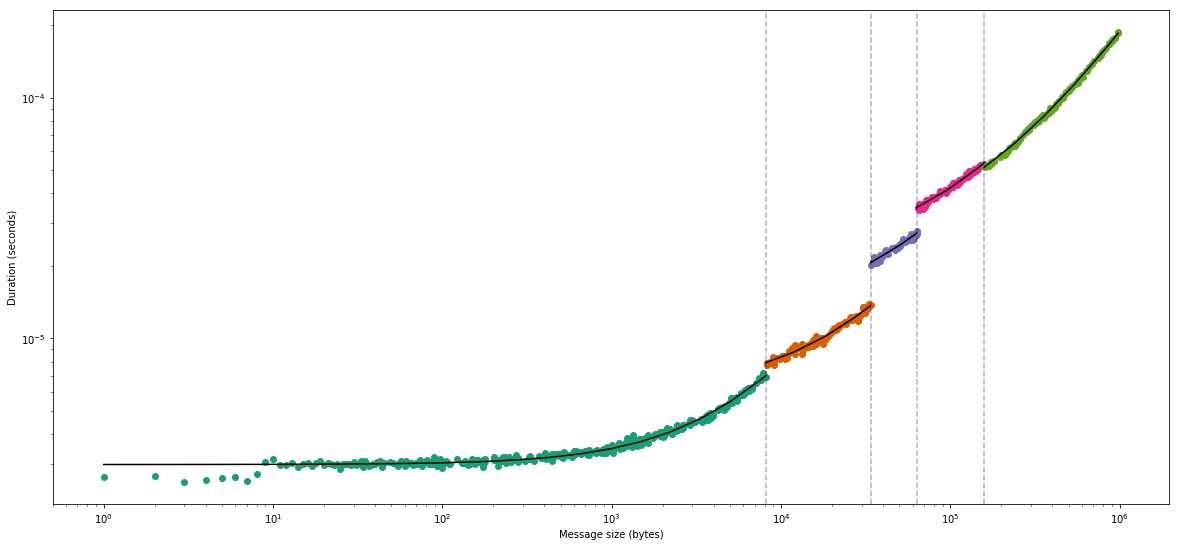

In [15]:
draw_plot(reg_pingpong)

In [16]:
breakpoints_pingpong = set(reg_pingpong.breakpoints)
breakpoints_pingpong.difference_update([158541])
breakpoints_pingpong

{8133, 33956, 63305}

## Better regressions

Let's use the same breakpoints everywhere and stop “cleaning” the datasets.

In [17]:
breakpoints = list(sorted(set.union(breakpoints_send, breakpoints_isend, breakpoints_recv, breakpoints_pingpong)))
breakpoints

[8133, 8260, 10079, 15831, 33956, 63305]

In [18]:
breakpoints.remove(8260)
breakpoints.remove(10079)
assert threshold in breakpoints
breakpoints

[8133, 15831, 33956, 63305]

In [19]:
def my_join(*values, inner_sep=':', outer_sep=';'):
    result = []
    for items in zip(*values):
        result.append(inner_sep.join([str(it) for it in items]))
    return outer_sep.join(result)

def regression_to_str(reg_df, drop_threshold=None, keys=['intercept', 'coefficient']):
    if drop_threshold is not None:
        reg_df.loc[reg_df.min_x >= drop_threshold, 'intercept'] = 0
        reg_df.loc[reg_df.min_x >= drop_threshold, 'coefficient'] = 0
    reg_df.loc[reg_df.min_x < 0, 'min_x'] = 0
    reg_df.min_x = reg_df.min_x.astype(int)
    reg_df.loc[reg_df.coefficient < 0, 'coefficient'] = 0
    reg_df.loc[reg_df.intercept < 0, 'intercept'] = 0
    reg_df.sort_values(by='min_x')
    values = [reg_df.min_x]
    for key in keys:
        values.append(reg_df[key])
    return my_join(*values)

### MPI_Send

-inf < x ≤ 8.133e+03
	y ~ 9.636e-11x + 2.965e-07
8.133e+03 < x ≤ 1.583e+04
	y ~ 9.999e-11x + 4.117e-06
1.583e+04 < x ≤ 3.396e+04
	y ~ 1.100e-10x + 3.902e-06
3.396e+04 < x ≤ 6.330e+04
	y ~ 1.264e-10x + 8.556e-06
6.330e+04 < x ≤ inf
	y ~ 8.107e-11x + 1.603e-05


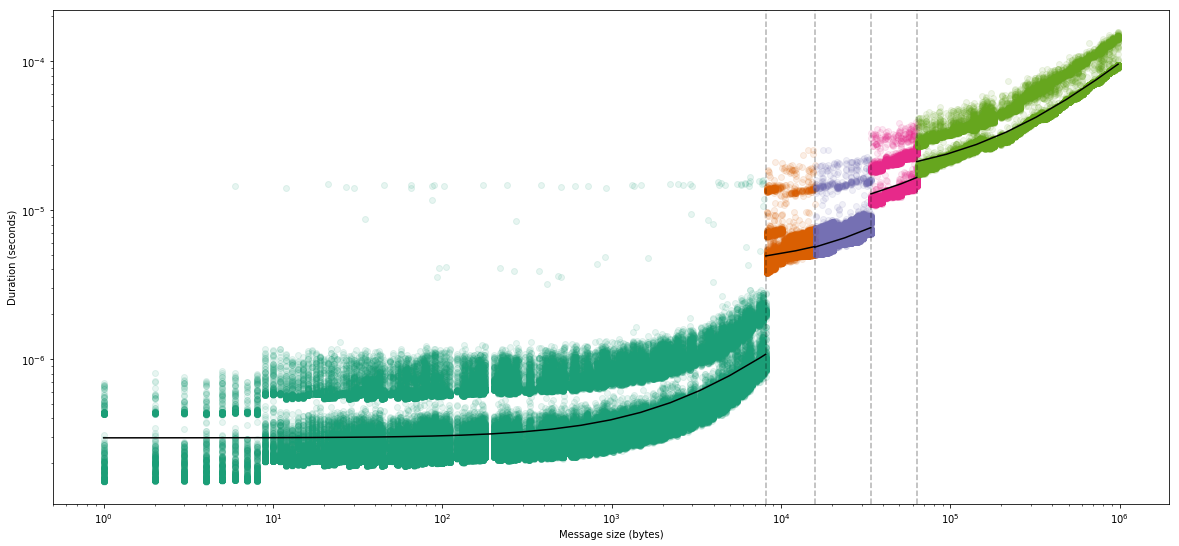

In [20]:
reg_send = pytree.compute_regression(x=df_send.msg_size, y=df_send.duration, breakpoints=breakpoints)
print(reg_send)
draw_plot(reg_send, alpha=0.1)

In [21]:
reg_send_str = regression_to_str(reg_send.to_pandas(), drop_threshold=threshold)
reg_send_str

'0:2.9654918472829634e-07:9.636195922971908e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0'

### MPI_Isend

-inf < x ≤ 8.133e+03
	y ~ 7.051e-11x + 6.931e-07
8.133e+03 < x ≤ 1.583e+04
	y ~ 1.245e-10x + 3.602e-07
1.583e+04 < x ≤ 3.396e+04
	y ~ 4.130e-11x + 2.977e-06
3.396e+04 < x ≤ 6.330e+04
	y ~ 3.293e-11x + 3.133e-06
6.330e+04 < x ≤ inf
	y ~ -8.507e-14x + 6.940e-07


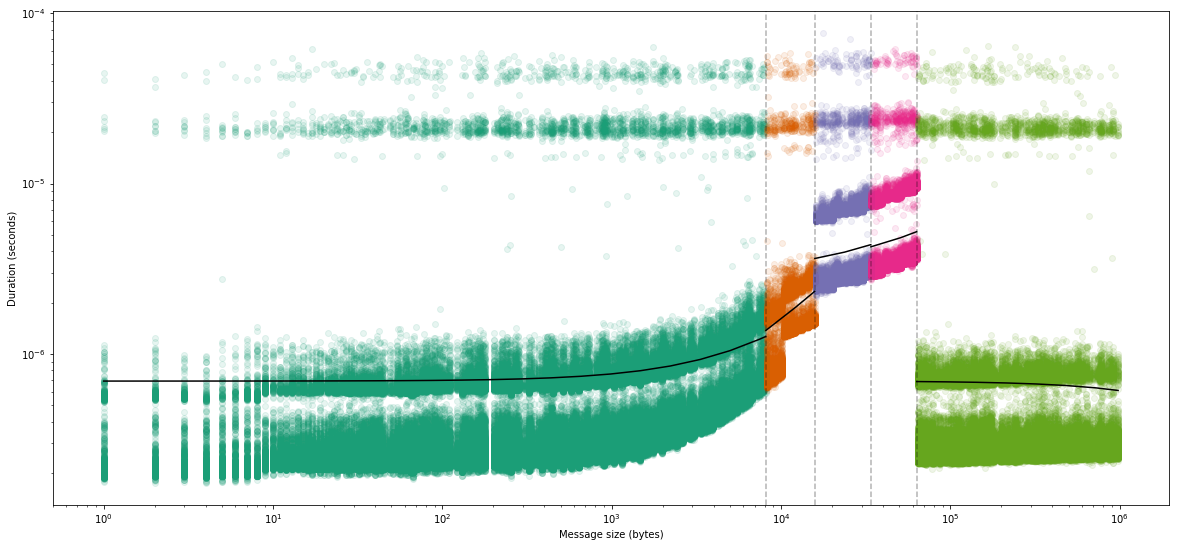

In [22]:
reg_isend = pytree.compute_regression(x=df_isend.msg_size, y=df_isend.duration, breakpoints=breakpoints)
print(reg_isend)
draw_plot(reg_isend, alpha=0.1)

In [23]:
reg_isend_str = regression_to_str(reg_isend.to_pandas())
reg_isend_str

'0:6.93122952108322e-07:7.051204536228499e-11;8133:3.601990790153314e-07:1.2449128895712003e-10;15831:2.977016881030904e-06:4.130261264964205e-11;33956:3.1334661540668004e-06:3.293458765282178e-11;63305:6.939993663604218e-07:0.0'

### MPI_Recv

-inf < x ≤ 8.133e+03
	y ~ 8.456e-11x + 1.375e-06
8.133e+03 < x ≤ 1.583e+04
	y ~ 1.040e-10x + 1.062e-06
1.583e+04 < x ≤ 3.396e+04
	y ~ 9.881e-11x + 1.199e-06
3.396e+04 < x ≤ 6.330e+04
	y ~ 1.074e-10x + 1.303e-06
6.330e+04 < x ≤ inf
	y ~ 7.946e-11x + 1.102e-05


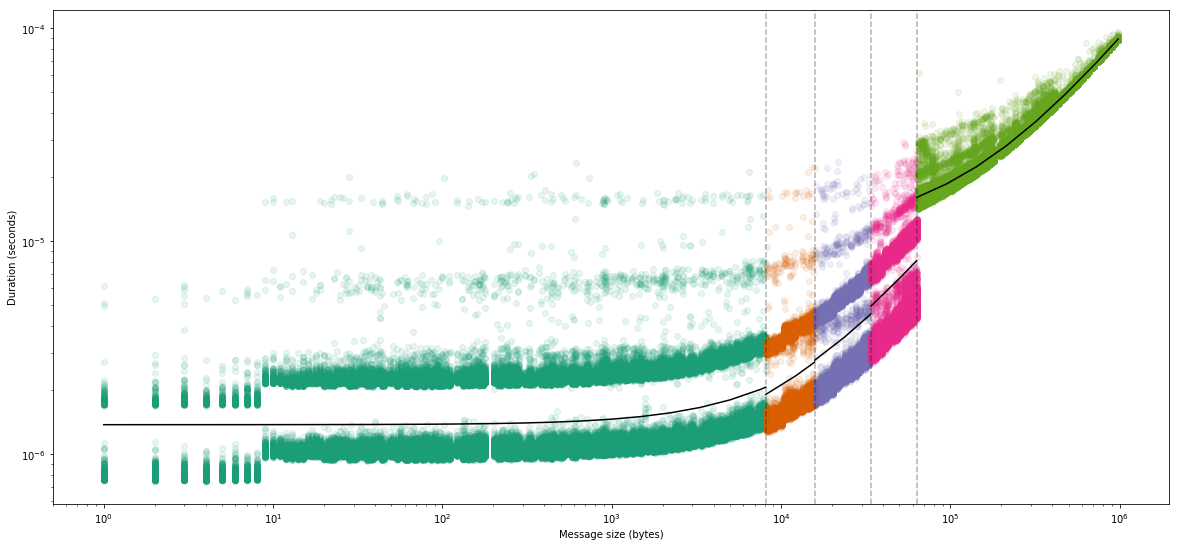

In [24]:
reg_recv = pytree.compute_regression(x=df_recv.msg_size, y=df_recv.duration, breakpoints=breakpoints)
print(reg_recv)
draw_plot(reg_recv, alpha=0.1)

In [25]:
reg_recv_str = regression_to_str(reg_recv.to_pandas(), drop_threshold=threshold)
reg_recv_str

'0:1.3754300044375224e-06:8.456019002037343e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0'

### Pingpong

-inf < x ≤ 8.133e+03
	y ~ 4.920e-10x + 2.994e-06
8.133e+03 < x ≤ 1.583e+04
	y ~ 2.363e-10x + 5.969e-06
1.583e+04 < x ≤ 3.396e+04
	y ~ 2.256e-10x + 6.055e-06
3.396e+04 < x ≤ 6.330e+04
	y ~ 2.275e-10x + 1.293e-05
6.330e+04 < x ≤ inf
	y ~ 1.621e-10x + 2.585e-05


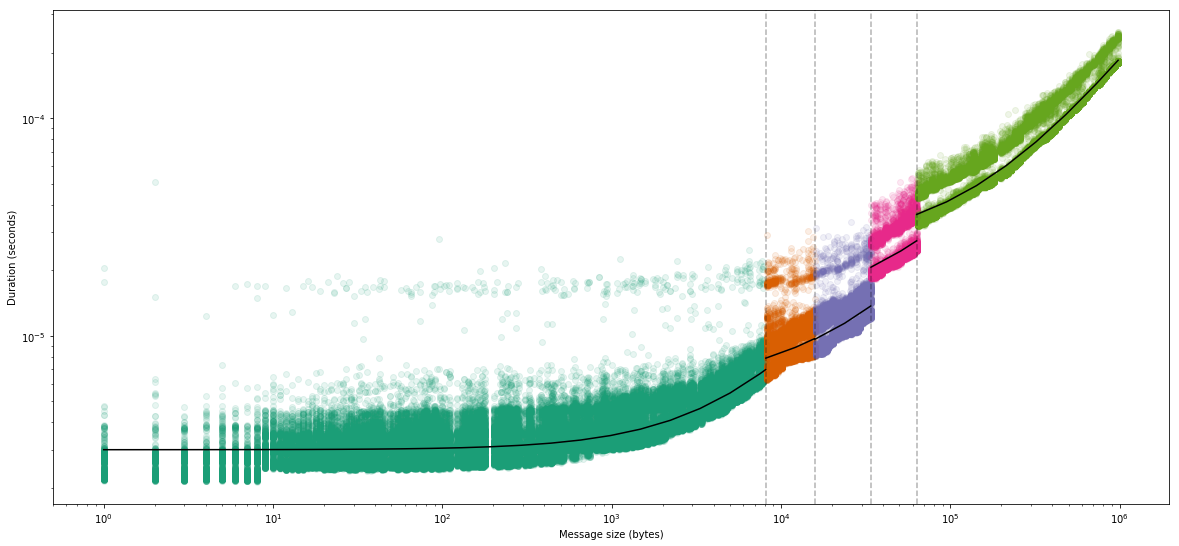

In [26]:
reg_pingpong = pytree.compute_regression(x=df_pingpong.msg_size, y=df_pingpong.duration, breakpoints=breakpoints)
print(reg_pingpong)
draw_plot(reg_pingpong, alpha=0.1)

In [27]:
df_pingpong['duration_transfer'] = df_pingpong.duration / 2
df_pingpong['rcv_duration'] = df_pingpong.apply(lambda row: reg_recv.predict(row['msg_size']), axis=1)
df_pingpong.loc[df_pingpong.msg_size < threshold, 'duration_transfer'] -= df_pingpong.rcv_duration

-inf < x ≤ 8.133e+03
	y ~ 1.699e-10x + 1.135e-07
8.133e+03 < x ≤ 1.583e+04
	y ~ 1.182e-10x + 2.985e-06
1.583e+04 < x ≤ 3.396e+04
	y ~ 1.128e-10x + 3.027e-06
3.396e+04 < x ≤ 6.330e+04
	y ~ 1.137e-10x + 6.464e-06
6.330e+04 < x ≤ inf
	y ~ 8.107e-11x + 1.292e-05


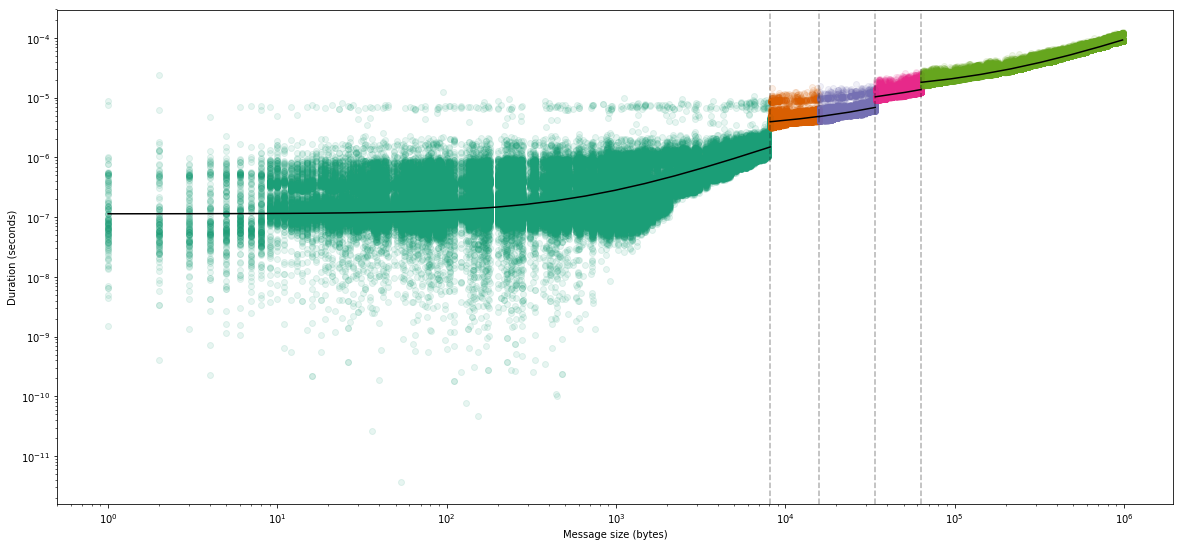

In [28]:
reg_transfer = pytree.compute_regression(x=df_pingpong.msg_size, y=df_pingpong.duration_transfer, breakpoints=breakpoints)
print(reg_transfer)
draw_plot(reg_transfer, alpha=0.1)

In [29]:
df_reg_transfer = reg_transfer.to_pandas()
df_reg_transfer

,MSE,RSS,coefficient,intercept,max_x,min_x,statsmodels_coefficient,statsmodels_intercept
0,1.508507e-13,2.753025e-08,1.698545e-10,1.134737e-07,8.133000e+03,-inf,1.698545e-10,1.134737e-07
1,7.792635e-13,1.792306e-08,1.181586e-10,2.984698e-06,1.583100e+04,8.133000e+03,1.181586e-10,2.984698e-06
2,9.130755e-13,2.602265e-08,1.128036e-10,3.027478e-06,3.395600e+04,1.583100e+04,1.128036e-10,3.027478e-06
3,3.801834e-12,9.884769e-08,1.137422e-10,6.463918e-06,6.330500e+04,3.395600e+04,1.137422e-10,6.463918e-06
4,1.397917e-11,1.425875e-06,8.107053e-11,1.292490e-05,inf,6.330500e+04,8.107053e-11,1.292490e-05


In [30]:
df_reg_transfer['bandwidth_factor'] = 1/(df_reg_transfer.coefficient*expected_bandwidth)
df_reg_transfer['latency_factor']   = df_reg_transfer.intercept/expected_latency

pandas.set_option('display.float_format', lambda x: '%.2e' % x)
df_reg_transfer

,MSE,RSS,coefficient,intercept,max_x,min_x,statsmodels_coefficient,statsmodels_intercept,bandwidth_factor,latency_factor
0,1.51e-13,2.75e-08,1.70e-10,1.13e-07,8.13e+03,-inf,1.70e-10,1.13e-07,4.71e-01,1.13e+00
1,7.79e-13,1.79e-08,1.18e-10,2.98e-06,1.58e+04,8.13e+03,1.18e-10,2.98e-06,6.77e-01,2.98e+01
2,9.13e-13,2.60e-08,1.13e-10,3.03e-06,3.40e+04,1.58e+04,1.13e-10,3.03e-06,7.09e-01,3.03e+01
3,3.80e-12,9.88e-08,1.14e-10,6.46e-06,6.33e+04,3.40e+04,1.14e-10,6.46e-06,7.03e-01,6.46e+01
4,1.40e-11,1.43e-06,8.11e-11,1.29e-05,inf,6.33e+04,8.11e-11,1.29e-05,9.87e-01,1.29e+02


In [31]:
bandwidth_str = regression_to_str(df_reg_transfer, drop_threshold=threshold, keys=['bandwidth_factor'])
latency_str = regression_to_str(df_reg_transfer, drop_threshold=threshold, keys=['latency_factor'])

print(bandwidth_str)
print(latency_str)

min_lat_factor = df_reg_transfer.latency_factor.min()
max_bw_factor = df_reg_transfer.bandwidth_factor.max()

0:0.4709912642540426;8133:0.6770561715947873;15831:0.7091971477925826;33956:0.7033449540683548;63305:0.9867951082730284
0:1.1347371681807956;8133:29.84698135078078;15831:30.274775156187765;33956:64.63917831305292;63305:129.24904864614737


### Wtime

5.094848181818182e-06


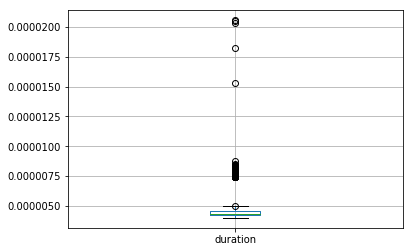

In [32]:
wtime_mean = df_wtime.duration.mean()
print(wtime_mean)
df_wtime.boxplot('duration')

### Test

8.090518732515405e-07


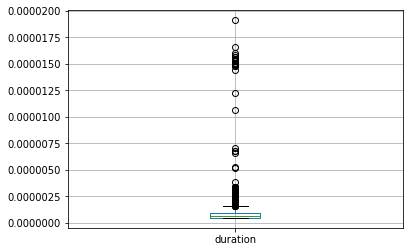

In [33]:
test_mean = df_test.duration.mean()
print(test_mean)
df_test.boxplot('duration')

### Iprobe

2.115437983643232e-07


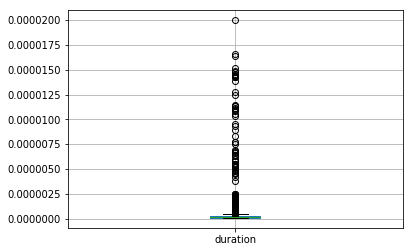

In [34]:
iprobe_mean = df_iprobe.duration.mean()
print(iprobe_mean)
df_iprobe.boxplot('duration')

## Loopback

In [35]:
loopback_archive_name = 'grenoble_2018-08-29_1808879.zip'
assert loopback_archive_name != archive_name

loopback_result = extract_zip(loopback_archive_name)

# Special processing for the Pingpong dataset
df_pingpong_loopback = loopback_result['exp/exp_PingPong.csv']
pingpong_send_loopback = df_pingpong_loopback[df_pingpong_loopback.op=='MPI_Send'].reset_index(drop=True)
pingpong_recv_loopback = df_pingpong_loopback[df_pingpong_loopback.op=='MPI_Recv'].reset_index(drop=True)
df_pingpong_loopback = pandas.DataFrame(dict(op = 'PingPong',
                   msg_size = pingpong_send_loopback.msg_size,
                   start    = pingpong_send_loopback.start,
                   duration = pingpong_recv_loopback.duration + pingpong_send_loopback.duration
              ))

df_recv_loopback = loopback_result['exp/exp_Recv.csv']

df_pingpong_loopback.head()

,op,msg_size,start,duration
0,PingPong,154133,1.71e-03,3.14e-05
1,PingPong,154133,1.75e-03,2.72e-05
2,PingPong,154133,1.78e-03,2.73e-05
3,PingPong,154133,1.80e-03,2.71e-05
4,PingPong,154133,1.83e-03,2.73e-05


### Loopback latency

7.814700000000001e-07


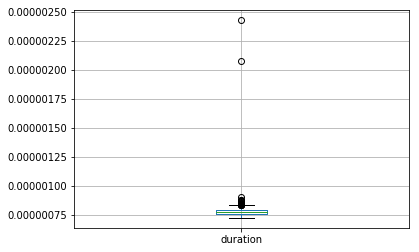

In [36]:
min_recv = df_recv_loopback[df_recv_loopback.msg_size == df_recv_loopback.msg_size.min()]
mean_min_recv = min_recv.duration.mean()
print(mean_min_recv)
min_recv.boxplot('duration')

1.134974e-06


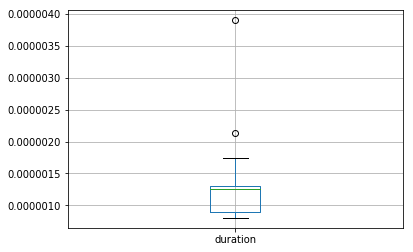

In [37]:
min_pingpong = df_pingpong_loopback[df_pingpong_loopback.msg_size == df_pingpong_loopback.msg_size.min()]
mean_min_pingpong = min_pingpong.duration.mean()
print(mean_min_pingpong)
min_pingpong.boxplot('duration')

In [38]:
loopback_latency = mean_min_pingpong/2 - mean_min_recv
theoretical_loopback_latency = max(0, loopback_latency / min_lat_factor)
theoretical_loopback_latency

0

### Loopback bandwidth

0.000108281982


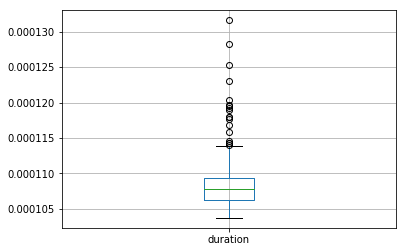

In [39]:
max_size = df_pingpong_loopback.msg_size.max()
max_pingpong = df_pingpong_loopback[df_pingpong_loopback.msg_size == max_size]
mean_max_pingpong = max_pingpong.duration.mean()
print(mean_max_pingpong)
max_pingpong.boxplot('duration')

In [40]:
loopback_bandwidth = 2/(mean_max_pingpong/max_size)
theoretical_loopback_bandwidth = loopback_bandwidth / max_bw_factor
theoretical_loopback_bandwidth

18348422228.142723

## XML generation

In [41]:
config = f'''
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="{reg_send_str}"/>
        <prop id="smpi/or" value="{reg_recv_str}"/>
        <prop id="smpi/ois" value="{reg_isend_str}"/>
        <prop id="smpi/bw-factor" value="{bandwidth_str}"/>
        <prop id="smpi/lat-factor" value="{latency_str}"/>
        <prop id="smpi/async-small-thresh" value="{threshold}"/>
        <prop id="smpi/send-is-detached-thresh" value="{threshold}"/>
        <prop id="smpi/wtime" value="{wtime_mean}"/>
        <prop id="smpi/iprobe" value="{iprobe_mean}"/>
        <prop id="smpi/test" value="{test_mean}"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="0-31" speed="1" core="32" bw="{expected_bandwidth*1e-9}GBps" lat="{'%.2f' % (expected_latency*1e6)}us" loopback_bw="{theoretical_loopback_bandwidth*1e-9}GBps" loopback_lat="{theoretical_loopback_latency*1e6}us"/>
    </AS>
</platform>
'''

print(config)


<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.9654918472829634e-07:9.636195922971908e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375224e-06:8.456019002037343e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.93122952108322e-07:7.051204536228499e-11;8133:3.601990790153314e-07:1.2449128895712003e-10;15831:2.977016881030904e-06:4.130261264964205e-11;33956:3.1334661540668004e-06:3.293458765282178e-11;63305:6.939993663604218e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4709912642540426;8133:0.6770561715947873;15831:0.7091971477925826;33956:0.7033449540683548;63305:0.9867951082730284"/>
        <prop id="smpi/lat-factor" value="0:1.1347371681807956;8133:29.84698135078078;15831:30.274775156187765;33956:64.63917831305292;63